## Stage-1 : Single IRS component on ground between Transmitter & Receiver

In [5]:
import time
for i in [1,2,3]:
    time.sleep(1)
    print(i, end=" ")
    

1 2 3 

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class Error(Exception):     #Custom Error Class
    pass
class Invalid_Input(Error):      #Custom error for handling invalid input
    pass

global Lambda,R
global h_t,h_r 
global D,hd,l  

#Test data below
# D = 12      #Seperation between Tx & Rx
# h_t=10      
# h_r=5
# hd = h_t - h_r
# l=np.sqrt((hd**2)+(D**2))       # LOS Path length
# # print(l)
# c= 3*(10**8)
# f= 2.4*(10**9)
# Lambda=c/f
# pos=np.array([7]) #Position of IRS Element

Flag=0
def Exception_Checker(List,Variable):       #Raises Custom exceptions for inavlid inputs
    global Flag
    try:
        if  Variable<=List[1] and Variable>=List[0]:
            pass
        else:
            Flag=4
            raise Invalid_Input
            
    except Invalid_Input:
        print("Enter the value in specified range")
    
        
def Quit(Flag):     #Function to stop execution when invalid inputs are given
    if Flag==4:
        exit()

# Inputs for various parameters        
try:
    D=float(input("Enter the Distance between Tx & Rx Antenna (between 5m - 50m) : "))
    Exception_Checker([5,50],D)
    Quit(Flag)
    
    h_t=float(input("Enter the height of Tx Antenna (between 8m - 12m) : "))
    Exception_Checker([8,12],h_t)
    Quit(Flag)

    h_r=float(input("Enter the height of Rx Antenna (between 3m - 8m) : "))
    Exception_Checker([3,8],h_r)
    Quit(Flag)

    f=float(input("Enter the frequency of signal (between 1GHz - 5Ghz) : "))
    Exception_Checker([1,5],f)
    Quit(Flag)

    pos=float(input(f"Enter the position of IRS (between {D/4} - {3*D/4}) : "))
    Exception_Checker([D/4,3*D/4],pos)
    Quit(Flag)

except ValueError:
    Flag=4
    print("Enter only Integers in given range")

Quit(Flag)

hd = abs(h_t - h_r)
l=np.sqrt((hd**2)+(D**2))       # LOS Path length
c= 3*(10**8)
Lambda=c/(f*(10**9))      # Wavelength


class IRS:

    @staticmethod
    def Distance(pos,h_t=10,h_r=5):             # Function takes Postion of IRS (pos) as input                                
        r1=np.sqrt((pos**2)+(h_t**2))           # and returns the total distance traversed by wave(d)         
        r2=np.sqrt(((D-pos)**2)+(h_r**2))        
        d=r1+r2
        return d
    
    def Gamma(pos):             #Reflection Coefficient for each IRS element
        R=complex(np.cos((2*np.pi*(pos-l))/Lambda),np.sin((2*np.pi*(pos-l))/Lambda))
        return abs(R)

    @staticmethod
    def AF_Phase(Distance):                                 # Analytical Method to find AF & Phase difference of received signal
        a=(Lambda/(4*np.pi))*(1/l)*np.cos((2*np.pi*l)/Lambda)
        b=(-1)*(Lambda/(4*np.pi))*(1/l)*np.sin((2*np.pi*l)/Lambda)
        x=0
        for i in range(len(Distance)):
            M = (Lambda/(4*np.pi))*(IRS.Gamma(Distance[i])/Distance[i])
            phase=((-2)*np.pi*(l))/Lambda
            a += (M*np.cos(phase))
            b += (M*np.sin(phase))
            x += (2*np.pi*(Distance[i])/Lambda)
                  
        AF=(abs(complex(a,b)))**2
        
        Phase=x-((2*np.pi*l)/Lambda)
        while(True):
            if Phase <= -360:
                Phase+=360
            elif Phase >= 360:
                Phase-=360
            elif -360<=Phase and Phase<=360:
                break

        return AF,Phase

    @staticmethod
    def Attenuation_Factor(Distance):         # Attenuation Factor using Derived Formula
        x=0
        y=0
        for i in range(len(Distance)):
            x+=(1/Distance[i])
            y+=Distance[i]
        AF=((Lambda/(4*np.pi))**2)*(((1/l)+x)**2)
        Phase=2*np.pi*(y-l)/Lambda

        while(True):
            if Phase <= -360:
                Phase+=360
            elif Phase >= 360:
                Phase-=360
            elif -360<=Phase and Phase<=360:
                break
        return AF,Phase

           
Stage1= IRS()              #object instantiation
Distance=np.array([Stage1.Distance(pos)])
AF,Phase=Stage1.AF_Phase(Distance)
print("Total Distance travelled by reflected wave :",Distance)
print(f"Attenuation Factor & Phase difference(degree) of received signal are {AF} & {Phase} respectively")

AF_Derived,Phase_Derived=Stage1.Attenuation_Factor(Distance)
print("Attenuation Factor from derived formula :",AF_Derived)
print("Phase Difference(degree) from derived formula :",Phase_Derived)



Total Distance travelled by reflected wave : [[19.27762343]]
Attenuation Factor & Phase difference(degree) of received signal are 1.641382162657347e-06 & [315.54777027] respectively
Attenuation Factor from derived formula : [1.64138216e-06]
Phase Difference(degree) from derived formula : [315.54777027]


## Attenuation v/s Phase of Reflection Coefficient 

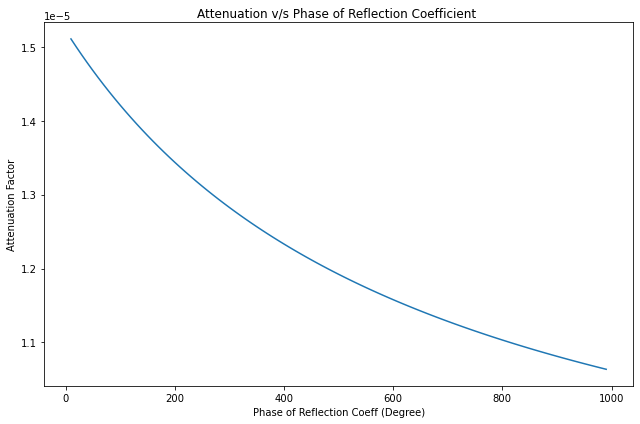

In [13]:
#Using Test Data
D = 12      #Seperation between Tx & Rx
h_t=10      
h_r=5
hd = h_t - h_r
l=np.sqrt((hd**2)+(D**2))       # LOS Path length
c= 3*(10**8)
f= 2.4*(10**9)
Lambda=c/f
Initial_Phase=10
Final_Phase=1000
Step_size=10
Phase=np.arange(Initial_Phase,Final_Phase,Step_size)
# print(Phase)
AF=np.array([])
for i in Phase:
    d=((i*Lambda)/(2*np.pi))+l
    AF=np.append(AF,((Lambda/(4*np.pi))**2)*((1/l)+(1/d)))
plt.plot(Phase,AF)
plt.xlabel("Phase of Reflection Coeff (Degree)") 
plt.ylabel("Attenuation Factor")
plt.title("Attenuation v/s Phase of Reflection Coefficient ")
plt.tight_layout(rect=[0,0,1.5,1.5])
plt.show()   

## Stage-2 : Multiple IRS component on ground between Transmitter & Receiver

In [3]:
pos=np.arange(D/4,3*D/4,0.06)       # Position of IRS components of 60mm length between D/4 distance from Tx & D/4 away from Rx
Stage2= IRS()       #Object instantiation
Distance=np.array([])
with open('Positions_Stage2.csv',"a") as f: #Writing the traversed path onto a file
    for i in pos:
        x=Stage2.Distance(i)
        Distance=np.append(Distance,x)
        f.write(str(x))
        f.write("\n")

AF,Phase=Stage2.AF_Phase(Distance)
print(f"Attenuation Factor & Phase difference(degree) of received signal are {AF} & {Phase} respectively")

AF_Derived,Phase_Derived=Stage1.Attenuation_Factor(Distance)
print("Attenuation Factor from derived formula :",AF_Derived)
print("Phase Difference(degree) from derived formula :",Phase_Derived)



Attenuation Factor & Phase difference(degree) of received signal are 0.0026417484747550536 & 230.40160872494744 respectively
Attenuation Factor from derived formula : 0.0026417484747550553
Phase Difference(degree) from derived formula : 230.4016087249911


## Stage-3 : Two walls containing Multiple IRS components


In [4]:
# Inputs for various parameters
try:
    D=float(input("Enter the Distance between Tx & Rx Antenna (between 5m - 50m) : "))
    Exception_Checker([5,50],D)
    Quit(Flag)
    
    h_t1=float(input("Enter the Distance of Tx Antenna from wall 1 (between 2m - 20m) : "))
    Exception_Checker([2,20],h_t1)
    Quit(Flag)

    h_r1=float(input("Enter the Distance of Rx Antenna from wall 1 (between 2m - 20m) : "))
    Exception_Checker([2,20],h_r1)
    Quit(Flag)

    h_t2=float(input("Enter the Distance of Tx Antenna from wall 2 (between 2m - 20m) : "))
    Exception_Checker([2,20],h_t2)
    Quit(Flag)

    h_r2=float(input("Enter the Distance of Rx Antenna from wall 2 (between 2m - 20m) : "))
    Exception_Checker([2,20],h_r2)
    Quit(Flag)

    f=float(input("Enter the frequency of signal (between 1GHz - 5Ghz) : "))
    Exception_Checker([1,5],f)
    Quit(Flag)

except ValueError:
    Flag=4
    print("Enter only Integers in given range")

Quit(Flag)
# h_t2=8
# h_r2=6
pos_Wall_1=np.arange(D/4,3*D/4,0.06)       # Postions of IRS components of 60mm length between D/4 distance from Tx & D/4 away from Rx on wall-1
pos_Wall_2=np.arange(D/4,3*D/4,0.06)       # Postions of IRS components of 60mm length between D/4 distance from Tx & D/4 away from Rx on wall-2
Stage3= IRS() #Object Instantiation

Distance=np.array([])

with open('Distance_Traversed_Stage3.csv',"a") as f:    #Storing the distance traversed by wave for each IRS component
    for i in pos_Wall_1:
        x=Stage3.Distance(i,h_t,h_r)
        Distance=np.append(Distance,x)
        f.write(str(x))
        f.write("\n")
    for i in pos_Wall_2:
        x=Stage3.Distance(i,h_t2,h_r2)
        Distance=np.append(Distance,x)
        f.write(str(x))
        f.write("\n")
with open("Distance_Traversed_Stage3.csv","r") as f:
    Data=f.read()
    Data=Data.splitlines()

D=np.array([])
for i in Data:  #distance traversed by wave for each IRS component
    D=np.append(D,float(i))

# print(type(D))
AF,Phase=Stage3.AF_Phase(D)
print(f"Attenuation Factor & Phase difference(degree) of received signal are {AF} & {Phase} respectively")

AF_Derived,Phase_Derived=Stage1.Attenuation_Factor(D)
print("Attenuation Factor from derived formula :",AF_Derived)
print("Phase Difference(degree) from derived formula :",Phase_Derived)



Attenuation Factor & Phase difference(degree) of received signal are 0.1351886010632874 & 151.49210320203565 respectively
Attenuation Factor from derived formula : 0.13518860106328756
Phase Difference(degree) from derived formula : 151.4921032008715
